In [1]:
import numpy as np
import gym
from gym import wrappers
import time
import seaborn
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from matplotlib import colors

In [2]:
def evaluate_policy(env, policy, err=[], t=[], gamma=0.9, theta=0.00001, render=False):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    #err=[]
    #k=[]
    #t=[]
    i=0
    V = np.zeros(env.unwrapped.nS)
    while True:
        delta = 0
        start=time.time()
        # For each state, perform a "full backup"
        for s in range(env.unwrapped.nS):
            vs = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    #
                    vs +=  action_prob * prob * (reward + gamma * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(vs - V[s]))
            V[s] = vs
        end=time.time()    
        ti=end-start
        t.append(ti)
        #print(t)
        err.append(delta)
        #k.append(i)
        i=i+1
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [3]:
def policy_improvement(env, V, policy, gamma=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + gamma * V[next_state])
        return A
    
    
    # Will be set to false if we make any changes to the policy
    policy_stable = True
        
    # For each state...
    for s in range(env.nS):
        # The best action we would take under the current policy
        chosen_a = np.argmax(policy[s])
            
        # Find the best action by one-step lookahead
        # Ties are resolved arbitarily
        action_values = one_step_lookahead(s, V)
        best_a = np.argmax(action_values)
            
        # Greedily update the policy
        if chosen_a != best_a:
            policy_stable = False
        policy[s] = np.eye(env.nA)[best_a]
        
    # If the policy is stable we've found an optimal policy. Return it
    return policy_stable

In [4]:
def policy_iteration(env, theta=1e-20, gamma=0.9, render=False):
    # Start with a random policy
    policy = np.ones([env.unwrapped.nS, env.unwrapped.nA]) / env.unwrapped.nA
    score=[]
    #i = 0
    #t=[]
    #err=[]
    totaltime=0
    while True:
        t=[]
        err=[]
        V = evaluate_policy(env, policy, err, t, gamma, theta)
        score.append(np.mean(V))
        totaltime+=np.sum(t)
        if render == True:
            print('value iteration for this policy improvement is ', len(err))
            err=np.array(err)
            #kp=np.array(kp)
            t=np.array(t)
            
            plt.figure(figsize=[15,6])
            plt.subplot(1,2,1)
            line1, = plt.plot(err,color='r',label='error')
            plt.ylabel('error')
            plt.xlabel('iteration')
            plt.subplot(1,2,2)
            line2,=plt.plot(t,color='g',label='time')
            #plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
            plt.ylabel('time')
            plt.xlabel('iteration')
            plt.show()
        #print(t)
        #print(err)
        #print(kp)
        #i = i+1
        if policy_improvement(env, V, policy, gamma):
            #print ('Policy-iteration converged at iteration# %d.' %(i))
            
            break
    return policy, V, totaltime

In [5]:
def extract_policy(v, gamma = 0.9):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        q_sa = np.zeros(env.nA)
        for a in range(env.nA):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

In [6]:
def play_policy(env, policy, render=False):
    total_reward=0.
    observation = env.reset()
    while True:
        if render:
            env.render()
        action = np.random.choice(env.action_space.n, p=policy[observation])
        observation,reward,done,_ = env.step(action)
        total_reward += reward
        if done:
            break
    return total_reward

In [7]:
env_name  = 'FrozenLake-v1'
env = gym.make(env_name, is_slippery=False)
env = env.unwrapped

gamma = 0.9

value iteration for this policy improvement is  95


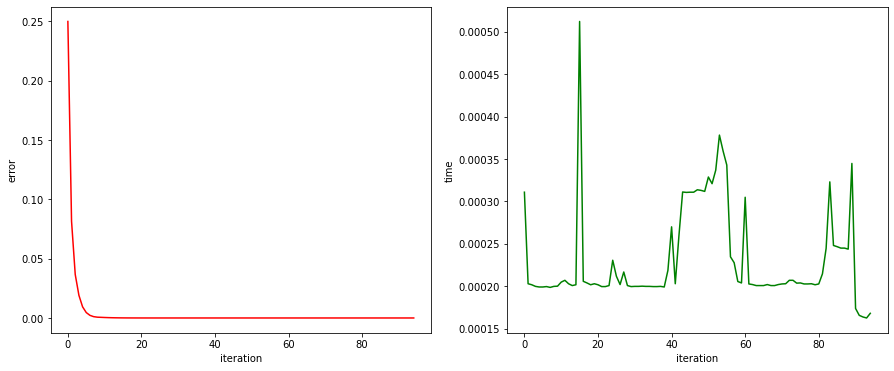

value iteration for this policy improvement is  7


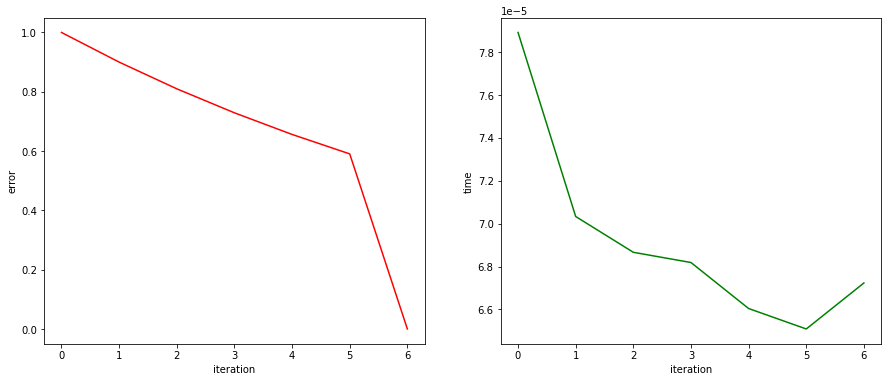

In [8]:
policy, V,_ = policy_iteration(env, theta=1e-20, gamma=gamma,render=True)

In [9]:
print(V)
print(policy)

[0.59049 0.6561  0.729   0.6561  0.6561  0.      0.81    0.      0.729
 0.81    0.9     0.      0.      0.9     1.      0.     ]
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


In [10]:
policy1 = extract_policy(V,gamma=gamma)
len(policy1)

16

In [11]:
policy1

array([1., 2., 1., 0., 1., 0., 1., 0., 2., 1., 1., 0., 0., 2., 2., 0.])

In [12]:
ps=[]
pscha=[]
for elem in policy1:
    ps.append(elem)
    if elem==1.0:
        pscha.append('D')
    elif elem==2.0:
        pscha.append('R')
    elif elem==0.0:
        pscha.append('L')
    else:
        pscha.append('U')

reshaped_policy=np.reshape(pscha,(4,4))
print(np.reshape(ps,(4,4)))
print(reshaped_policy)

[[1. 2. 1. 0.]
 [1. 0. 1. 0.]
 [2. 1. 1. 0.]
 [0. 2. 2. 0.]]
[['D' 'R' 'D' 'L']
 ['D' 'L' 'D' 'L']
 ['R' 'D' 'D' 'L']
 ['L' 'R' 'R' 'L']]


In [13]:
data=np.ones([4,4])*20
data[0,0]=10
data[1,1]=7
data[1,3]=7
data[3,0]=7
data[3,3]=0

In [14]:
# create discrete colormap
cmap = colors.ListedColormap(['green', 'red','orange','blue'])
bounds = [0,5,10,15,20]
norm = colors.BoundaryNorm(bounds, cmap.N)

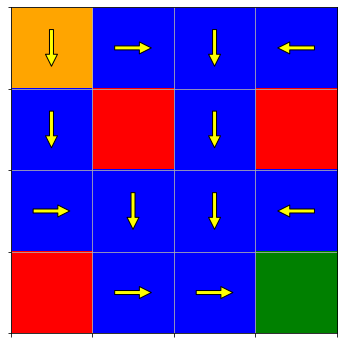

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(data, cmap=cmap)

# draw gridlines
ax.set_xticks(np.arange(-.5, 4.5, 1));
ax.set_yticks(np.arange(-.5, 4.5, 1));
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])

for iy in range(4):
    for ix in range(4):
    #print(x)
        if iy==1 and ix==1:
            continue
        if iy==1 and ix==3:
            continue
        if iy==3 and ix==0:
            continue
        if iy==3 and ix==3:
            continue
        if reshaped_policy[iy,ix]=='D':
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='blue')
            ax.annotate('', xy=(ix, iy+0.25), xytext=(ix, iy-0.25),
                arrowprops=dict(facecolor='yellow', shrink=0.05))
        elif reshaped_policy[iy,ix]=='L':
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='green')
            ax.annotate('', xy=(ix-0.25, iy), xytext=(ix+0.25, iy),
                arrowprops=dict(facecolor='yellow', shrink=0.05))
        elif reshaped_policy[iy,ix]=='U':  
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='blueviolet')
            ax.annotate('', xy=(ix, iy-0.25), xytext=(ix, iy+0.25),
                arrowprops=dict(facecolor='yellow', shrink=0.05))
        else:
            ax.annotate('', xy=(ix+0.25, iy), xytext=(ix-0.25, iy),
                arrowprops=dict(facecolor='yellow', shrink=0.05))
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='k')


            #print(reshaped_policy[iy,ix])

In [16]:
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):")
print(np.reshape(np.argmax(policy, axis=1), [4,4]))
print("")

print("Value Function:")
print(V)
print("")

print("Reshaped Grid Value Function:")
print(V.reshape([4,4]))
print("")

Policy Probability Distribution:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=left, 1=down, 2=right, 3=up):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]

Value Function:
[0.59049 0.6561  0.729   0.6561  0.6561  0.      0.81    0.      0.729
 0.81    0.9     0.      0.      0.9     1.      0.     ]

Reshaped Grid Value Function:
[[0.59049 0.6561  0.729   0.6561 ]
 [0.6561  0.      0.81    0.     ]
 [0.729   0.81    0.9     0.     ]
 [0.      0.9     1.      0.     ]]



In [17]:
env.render()
scores = evaluate_policy(env, policy, gamma = gamma)
print(scores.shape)


SFFF
FHFH
FFFH
HFFG
(16,)


In [18]:
print('Average scores = ', np.mean(scores))

Average scores =  0.5272993750000001


In [19]:
s=[]
for i in range(100):
    _,_,t=policy_iteration(env, gamma = gamma)
    s.append(t)

mu is 0.00717, sigma is 0.00215
Histogram of steps: μ=0.00717, sigma=0.00215


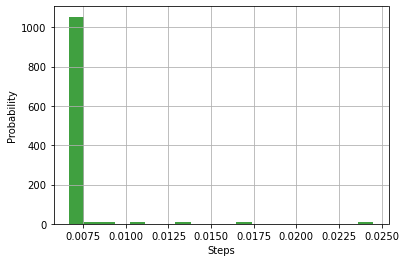

In [20]:
from scipy.stats import norm
s=np.array(s)
(mu, sigma) = norm.fit(s)
print("mu is {:.5f}, sigma is {:.5f}".format(mu, sigma))
n, bins, patches = plt.hist(s, 20, density=1, facecolor='green', alpha=0.75)
plt.xlabel('Steps')
plt.ylabel('Probability')
print("Histogram of steps: μ={:.5f}, sigma={:.5f}".format(mu, sigma))
plt.grid(True)
plt.show()